### Prelims

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### Model Architecture

- 전체 모델의 구조를 정의하는 기본 클래스이다.
- 주요 컴포넌트 : encoder, decoder, src_embed(입력 시퀀스를 임베딩하는 함수), tgt_embed(출력 시퀀스를 임베딩하는 함수), generator(디코더의 출력을 최종적으로 변환하여 출력 확률을 생헌하는 컴포넌트)로 구성이 되어있다.
- 주요 메서드 :
    - forward() - 마스크가 적용된 입출력 시퀀스를 받아 인코더와 디코더를 차례로 호출한다.
    - encode() - 입력 데이터를 임베딩한 후 인코더를 통해 처리한다.
    - decode() - 인코더의 출력 결과(memory)를 받아 디코더에서 처리한다.

In [2]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
        "입력 시퀀스 src를 인코더에 전달해 memory(연속 표현) 생성"
        "이후 memory와 디코더에 입력 시퀀스 tgt를 전달해 출력 생성"
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

- 디코더의 출력 결과를 실제 어휘 확률 분포로 변환
- 주요 컴퍼넌트
    
    proj : dmodel → vocab size로 변환하는 선형 계층
    
- 주요 메서드
    
    forward(x) : 디코더 출력 x에 대해 선형 변환을 수행한 후 log-softmax를 적용하여 확률 분포 반환

In [5]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

### Encoder와 Decoder 구조 상세 설명

##### 🚀 Encoder 🚀
- 인코더는 6개의 동일한 레이어(stack)으로 구성
- 레이어 구성 = 2개의 서브레이어(sub-layer)으로 이루어져있으며, residual connection과 layer normalization이 적용됨

In [6]:
"Encoder class"
class Encoder(nn.Module) :
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) #N개의 동일한 레이어 복제
        self.norm = LayerNorm(layer.size) #마지막 출력 정규화

    def forward(self, x, mask):
        for layer in self.layers: #레이어를 순차적으로 통과
            x = layer(x, mask)
        return self.norm(x) # 정규화 후 최종 출력
    
"Layernorm class"
class LayerNorm(nn.Module) :
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features)) # 가중치(초깃값 : 1)
        self.b_2 = nn.Parameter(torch.zeros(features)) # 편향(초깃값 : 0)
        self.eps = eps
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

- 서브레이어 : Residual Connection

In [7]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)  # 정규화
        self.dropout = nn.Dropout(dropout)  # 드롭아웃

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))  # 잔차 연결

- Encoder Layer 클래스  
2개의 서브 레이어로 구성 : Multi-head Self-Attention & Feed-forward Network

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn  # Self-Attention
        self.feed_forward = feed_forward  # Feed-Forward Network
        self.sublayer = clones(SublayerConnection(size, dropout), 2)  # 2개의 서브레이어
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))  # Self-Attention
        return self.sublayer[1](x, self.feed_forward)  # Feed-Forward


##### 🚀 Decoder 🚀  
- 디코더도 6개의 동일한 레이어로 구성이 되며, 3개의 서브레이어를 포함한다
    1. Multi-head Self-Attention
    2. Source-Target Attention (인코더의 출력과 디코더 입력 간의 상호작용)
    3. Feed-forward Network

In [14]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)  # N개의 동일한 DecoderLayer 생성
        self.norm = LayerNorm(layer.size)  # 출력값 정규화용 LayerNorm 초기화

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:  # N개의 DecoderLayer를 순차적으로 통과
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)  # 최종 출력에 LayerNorm 적용


"Decoder Layer : Self-Attention, Source-Target Attention, feed-forward, SublayerConnection 등을 거침"
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # 3개의 서브레이어

    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))  # Self-Attention. 자기 자신 참조
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))  # Source-Target Attention. 인코더의 출력 참조
        return self.sublayer[2](x, self.feed_forward)  # Feed-Forward 적용

"subsequent_mask 함수 : 미래 위치를 참조하지 않도록 디코더 입력에 마스크 생성(자신보다 뒤에 있는 단어는 참조하지 않도록)"
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # 상위 삼각 행렬
    return torch.from_numpy(subsequent_mask) == 0 # 미래 위치를 참조하지 않도록 False로 설정


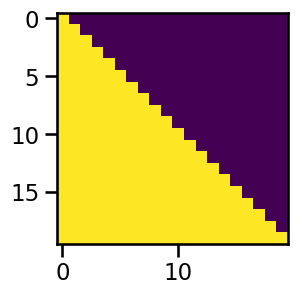

In [19]:
plt.figure(figsize=(3,3))
plt.imshow(subsequent_mask(20)[0])
None

### Attention

- Scale Dot Product Attention

In [20]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)  # Query(Key) 벡터의 차원
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)  # Query와 Key의 내적을 스케일링
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)  # 마스크 적용 (미래 위치 차단 등)
    p_attn = F.softmax(scores, dim=-1)  # Softmax로 가중치 계산
    if dropout is not None:
        p_attn = dropout(p_attn)  # 드롭아웃 적용 (선택)
    return torch.matmul(p_attn, value), p_attn  # 가중치를 Value에 곱해 출력 생성

- Multi-Head Attention

In [24]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0  # d_model이 h로 나누어 떨어져야 함
        self.d_k = d_model // h  # 각 헤드의 차원
        self.h = h  # 헤드의 개수
        self.linears = clones(nn.Linear(d_model, d_model), 4)  # Query, Key, Value, Output용 선형 변환
        self.attn = None  # Attention 가중치 저장
        self.dropout = nn.Dropout(p=dropout)  # 드롭아웃

    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)  # 모든 헤드에 동일한 마스크 적용
        nbatches = query.size(0)  # 배치 크기

    # 1) 선형 변환 및 차원 재조정: d_model => h x d_k
        query, key, value = [
        l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for l, x in zip(self.linears, (query, key, value))
    ]
    
    # 2) 모든 헤드에 대해 Attention 적용
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
    
    # 3) 헤드들을 결합(Concat)하고 최종 선형 변환 적용
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)  # 최종 출력


### Position-wise Feed-Forward Networks

In [25]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### Embeddings and Softmax

In [26]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### Positional Encoding

In [27]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

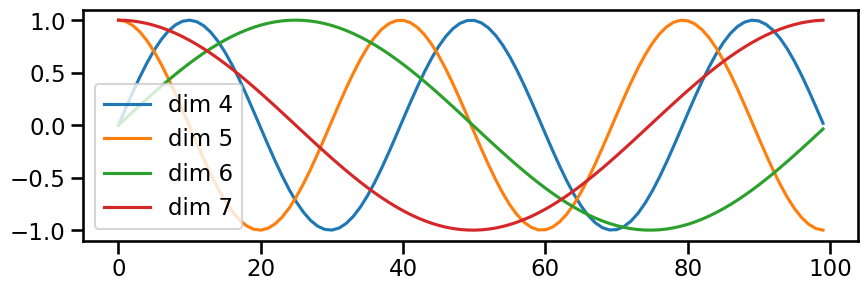

In [31]:
plt.figure(figsize=(10, 3))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

### Full Model

In [32]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model